This (Monte Carlo) is my (20HS20031) self project.

In [1]:
#Importing all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

#Installing the Portfolio Optimzation Library
!pip install PyPortfolioOpt
import yfinance as yf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.7 MB/s eta 0:00:00


In [2]:
tickers = ['RELIANCE.BO', 'HDFCBANK.BO', 'ICICIBANK.BO', 'INFY.BO', 'TCS.BO']
thelen = len(tickers)
price_data = []

for ticker in range(thelen):
    stock = yf.download(tickers[ticker], start='2021-04-01', end='2023-01-14')
    price_data.append(stock['Adj Close'])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns = tickers
print(df_stocks.head(),df_stocks.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            RELIANCE.BO  HDFCBANK.BO  ICICIBANK.BO      INFY.BO       TCS.BO
Date                                                                        
2021-04-01  2015.629761  1469.650269    590.407837  1366.926636  3072.682861
2021-04-05  1986.816650  1432.575439    567.743835  1391.447021  3143.921875
2021-04-06  1977.694092  1424.616577    562.574829  1392.433838  3167.749023
2021-04-07  1996.786621  1430.944092    574.105652  1411.280396  3174.445801
2021-04-08  1998.979980  1417.300537    573.310425  1420.703857  3218.848633             RELIANCE.BO  HDFCBANK.BO  ICICIBANK.BO      INFY.BO       TCS.BO
Date                                   

In [3]:
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe()
#May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('RELIANCE.BO', 0.09371), ('HDFCBANK.BO', 0.0), ('ICICIBANK.BO', 0.90629), ('INFY.BO', 0.0), ('TCS.BO', 0.0)])


In [4]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

In [5]:
for a in range(thelen):
  ticker_rx = df_stocks[[tickers[a]]].pct_change()
  ticker_rx = (ticker_rx+1).cumprod()
  ticker_rx2.append(ticker_rx[[tickers[a]]])
ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final

,RELIANCE.BO,HDFCBANK.BO,ICICIBANK.BO,INFY.BO,TCS.BO
Date,,,,,
2021-04-01,NaN,NaN,NaN,NaN,NaN
2021-04-05,0.985705,0.974773,0.961613,1.017938,1.023185
2021-04-06,0.981179,0.969358,0.952858,1.018660,1.030939
2021-04-07,0.990651,0.973663,0.972388,1.032448,1.033119
2021-04-08,0.991740,0.964379,0.971041,1.039342,1.047569
...,...,...,...,...,...
2023-01-09,1.288208,1.074605,1.479994,1.071609,1.048580
2023-01-10,1.269057,1.055701,1.457382,1.061431,1.037999
2023-01-11,1.252958,1.070165,1.469916,1.062189,1.051470


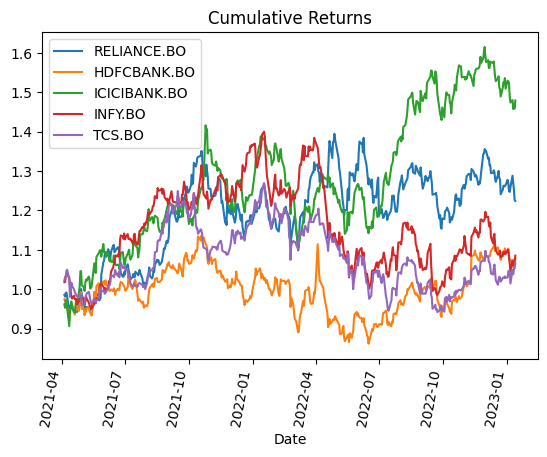

In [6]:
#Plot graph of Cumulative/HPR of all stocks
for i, col in enumerate(ticker_final.columns):
  ticker_final[col].plot()
plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(ticker_final.columns)
#Saving the graph into a JPG file
plt.savefig('CR.png', bbox_inches='tight')

In [7]:
#Taking Latest Values of Return
pret = []
pre1 = []
price =[]
for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stocks.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
ex_rtn=pre1.dot(sh_wt)
print('The weighted expected portfolio return for selected time period is'+ str(ex_rtn))
#ex_rtn = (ex_rtn)**0.5-(1) #Annualizing the cumulative return (will not affect outcome)
price=price.dot(sh_wt) #Calculating weighted value
print(ex_rtn, varsigma,price)

The weighted expected portfolio return for selected time period is[1.45517065]
[1.45517065] 0.15736552636799178 Date
2023-01-13    1022.63312
dtype: float64


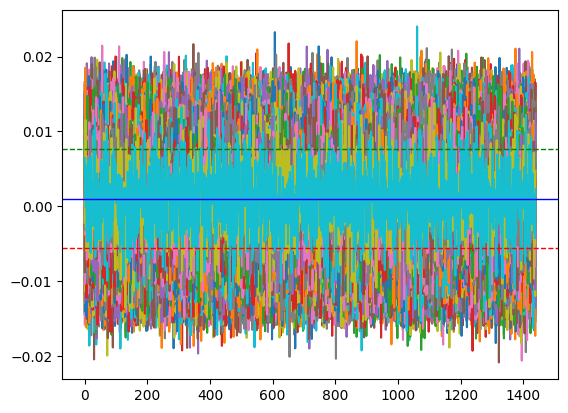

In [8]:
from scipy.stats import norm
import math
Time=1440 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
for i in range(10000): #10000 runs of simulation
  daily_returns=                     (np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
  plt.plot(daily_returns)
plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()

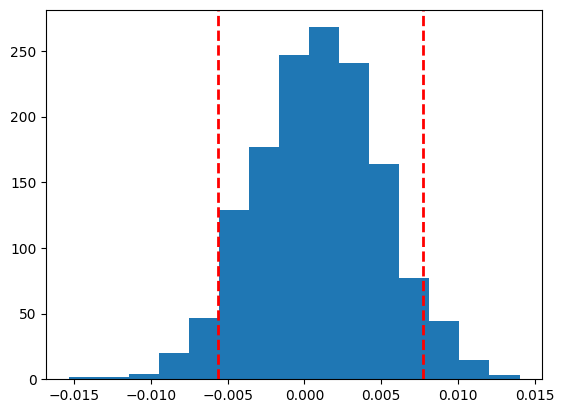

In [9]:
plt.hist(daily_returns,bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

In [10]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95))
pvalue = 1000 #portfolio value
print('$ Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.005621011879997226 0.00771582775357328
$ Amount required to cover minimum losses for one day is 5.6210118799972255
